In [1]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import math
import pandas as pd
from tqdm import  tqdm
from sklearn.model_selection import KFold
from numpy.fft import fft
import datetime
import json
import numpy as np
from scipy import stats

def prepare_data_from_horizon(df, horizon=12):
    
    data=df.copy()

    sel = np.concatenate([[1,2,3,4],
                         [12],
                         24*np.arange(1,9),
                         12+24*np.arange(1,9)])  
    sel=np.concatenate([sel,sel-1,sel+1])  
    
    ## lagged NO2 values
    for i in sel:
        if (i>=horizon):
            data["NO2 - "+str(i)] = data["NO2"].shift(i)

    ## lagged O3 values
    for i in 24*np.arange(1,4):
        if (i>=horizon):
            data["O3 - "+str(i)] = data["O3"].shift(i)

    ## Remove empty values
    data=data.dropna()

    X=data[list(set(data.columns)-set(['DATE',"NO2","O3"]))]
    y=data["NO2"]
  
    return X, y

#"data/dataEscAgui.csv"
def get_data(path):

    df = pd.read_csv(path,sep=";")

    # Prepare data
    data = df[["DATE","SPA.NO2","SPA.O3","MACC.NO2"]].copy()
    data["DATE"]=pd.to_datetime(data["DATE"],format="%Y-%m-%d %H:%M:%S")
    data = data.sort_values("DATE")
    data.columns = ["DATE","NO2","O3","CAMS"]

    ## Remove everything from 2020
    data=data[data["DATE"].astype(str)<"2020"]

    ## Fourier Columns
    freqs = [2922,1461,209,1465,4]
    l = 35064
    n = np.arange(len(data))
    fcols = []
    for f in freqs:
        data["c"+str(f)]=np.cos(n*2*np.pi*f/l)
        fcols.append("c"+str(f))
        data["s"+str(f)]=np.cos(n*2*np.pi*f/l)
        fcols.append("s"+str(f))

    data["NO2"]=np.log1p(data["NO2"])
    data["O3"]=np.log1p(data["O3"])
    data["CAMS"]=np.log1p(data["CAMS"])

    ## Calendar Variables 
    ## Calendar Variables do not bring better results and therefore
    ## removed
    
    return data

In [3]:
# Let's draw the predictions at a certain time
df_orig = get_data("../2018_2019_data/28079008.csv")

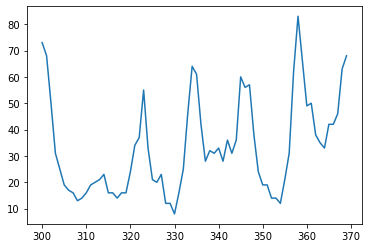

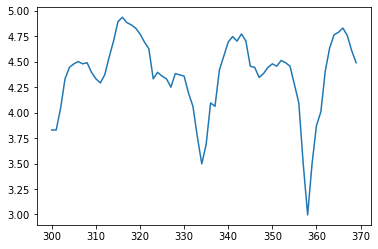

<AxesSubplot:>

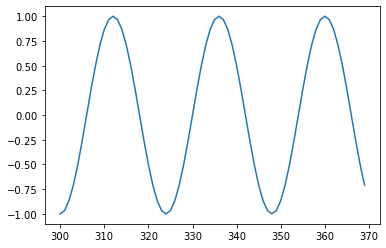

In [4]:
np.exp(df_orig["NO2"])[300:370].plot(kind="line")
plt.show()
df_orig["O3"][300:370].plot(kind="line")
plt.show()
df_orig["c1461"][300:370].plot(kind="line")

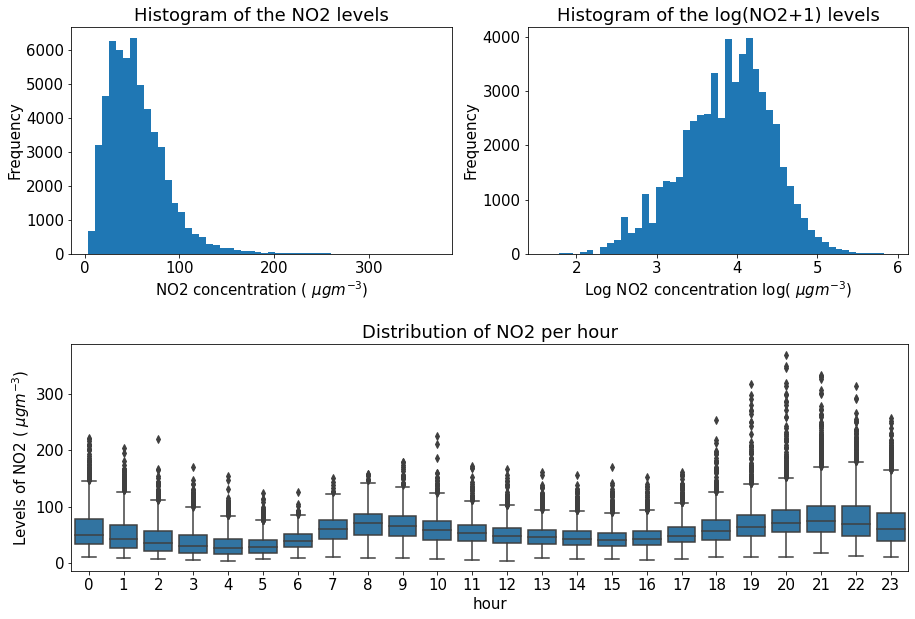

In [16]:
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.4)


plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})
plt.subplot(grid[0, 0])
plt.title("Histogram of the NO2 levels")
plt.xlabel('NO2 concentration ( $\mu g m^{-3}$)')
plt.ylabel('Frequency')
plt.hist(np.exp(df_orig["NO2"])-1,bins=50)

plt.subplot(grid[0, 1])
plt.title("Histogram of the log(NO2+1) levels")
plt.xlabel('Log NO2 concentration log( $\mu g m^{-3}$)')
plt.ylabel('Frequency')
plt.hist(df_orig["NO2"],bins=50)

plt.subplot(grid[1:3, :2])
temp_df = df_orig.copy()
temp_df["hour"]=temp_df["DATE"].dt.hour
temp_df["NO2"]=np.exp(temp_df["NO2"])
sns.boxplot(data=temp_df, x="hour",y="NO2",color="#1f77b4")
plt.title("Distribution of NO2 per hour")
plt.ylabel("Levels of NO2 ( $\mu g m^{-3}$)")
plt.savefig("../../perez2018probabilistic/histo_variance.png")
plt.show()

<AxesSubplot:xlabel='hour', ylabel='NO2'>

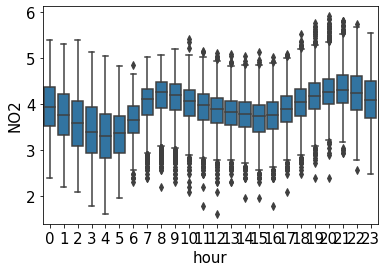

In [14]:
temp_df = df_orig.copy()
temp_df["hour"]=temp_df["DATE"].dt.hour
sns.boxplot(data=temp_df, x="hour",y="NO2",color="#1f77b4")

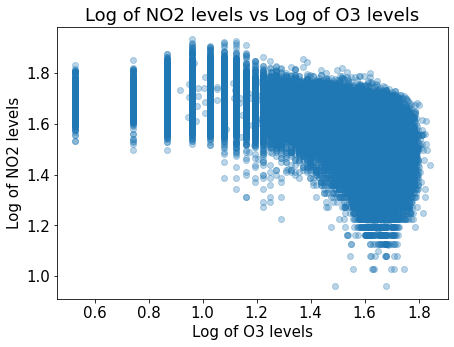

In [15]:
plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 15})

plt.title("Log of NO2 levels vs Log of O3 levels")
plt.xlabel("Log of O3 levels")
plt.ylabel("Log of NO2 levels")
plt.scatter(np.log1p(df_orig["O3"]),np.log1p(df_orig["NO2"]),alpha=.3)
plt.show()